# 타이타닉 생존자 예측

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

---
> <span style='font-size:20pt;'>Preparing dataset </span>
---

In [2]:
data_df = pd.read_csv('titanic.csv')
data_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


## Data info

- **PassengerId** : Unique ID of passenger
- **Survived** : 0 = No, 1 = Yes
- **pclass** : Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd)
- **sibsp** : # of siblings & spouses aboard the Titanic
- **parch** : # of parents / children aboard the Titanic
- **ticket** : Ticket number
- **cabin** : Cabin number
- **embarked** : Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

In [3]:
y_data = data_df[['Survived']]

In [4]:
del data_df['Survived']
x_data = data_df.copy()

---
> <span style='font-size:20pt;'> Feature engineering & Feature selection </span>
---

In [5]:
from sklearn.preprocessing import LabelEncoder

# LabelEncoder로 문자열을 간단한 숫자로 보기쉽게 바꿈
le = LabelEncoder()
x_data['Gender'] = le.fit_transform(x_data['Sex'])
x_data['Embarked'] = le.fit_transform(x_data['Embarked'].astype(str))

In [6]:
del x_data['PassengerId']
del x_data['Name']
del x_data['Ticket']
del x_data['Sex']
del x_data['Cabin']

In [7]:
# 3은 빈 열인데, 이게 3개밖에 안되서 삭제했음
drop_Embarked_3 = x_data[x_data['Embarked'] == 3].index
y_data = y_data.drop(drop_Embarked_3)
x_data = x_data.drop(drop_Embarked_3)

In [8]:
# Age의 빈부분을 중앙값으로 대체
x_data['Age'] = x_data['Age'].fillna(x_data['Age'].median(skipna=True))

In [9]:
# Fare열의 상위 15% 삭제
x_data = x_data[ x_data['Fare'] <= x_data['Fare'].quantile(.85) ]
y_data = y_data.loc[x_data.index]

---
> <span style='font-size:20pt;'> Train - Test split and Scaling, One-Hot Encoding </span>
---

* Pclass, Embarked, SibSp, Parch열을 OneHotEncoding함

In [14]:
from sklearn.model_selection import train_test_split

# 스플릿
X_train, X_test, y_train, y_test = \
            train_test_split(x_data, y_data, test_size=0.3, random_state=0)

In [15]:
from sklearn.preprocessing import OneHotEncoder

# OneHotEncoder 선언
# sparse 옵션 = OneHotEncode는 기본적으로 sparse matrix를 주기때문에
# 이 옵션을 꺼야 원본 행렬 데이터를 가져올수있음
# sparse matrix = 희소행렬, 1과 0만 있는 데이터에서 행렬 위치만을 저장하는 방식
one_hot = OneHotEncoder(sparse=False, dtype=int)

features = ['Pclass','Embarked','SibSp','Parch']
one_hot.fit(X_train[features])

X_train_onehot = pd.DataFrame(one_hot.transform(X_train[features]))
X_test_onehot = pd.DataFrame(one_hot.transform(X_test[features]))

In [17]:
columns_name = []
for name, category in zip(features, one_hot.categories_):
    columns_name += [name + '_' + str(x) for x in range(len(category))]
X_train_onehot.columns = columns_name
X_test_onehot.columns = columns_name

X_train_onehot = pd.concat([X_train_onehot, 
                X_train[['Age','Fare','Gender']].reset_index(drop=True)], axis=1)
X_test_onehot = pd.concat([X_test_onehot,
                X_test[['Age','Fare','Gender']].reset_index(drop=True)], axis=1)

---
> <span style='font-size:20pt;'>Model Training</span>
---

* XGBoost, GridSearchCv 사용

In [26]:
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# 검증에 필요한 KFold
cv = KFold(n_splits=4)

# Grid Search 기법에 필요한 파라미터 dict
parameter = {
        'n_estimators' : [ 1000 ],
        'max_depth' : [3,6,9],
        'min_child_weight' : [1,3,5],
        'gamma' : [ x/10.0 for x in range(0,5) ],
        'subsample' : [0.7],
        'colsample_bytree' : [0.8],
        'learning_rate' : [0.1],
        'n_jobs' : [4]
}

# 학습 및 예측 결과
grid_xgb_clf = GridSearchCV(
                    XGBClassifier(),
                    param_grid=parameter,
                    scoring='accuracy',
                    cv=cv,
                    verbose=1
                )

grid_xgb_clf.fit(X_train_onehot, y_train)
grid_xgb_pred = grid_xgb_clf.predict(X_test_onehot)

print(accuracy_score(y_test, grid_xgb_pred))
print(roc_auc_score(y_test, grid_xgb_pred))
print(classification_report(y_test, grid_xgb_pred))

Fitting 4 folds for each of 45 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  1.2min finished


0.8149779735682819
0.7887755102040815
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       147
           1       0.76      0.70      0.73        80

   micro avg       0.81      0.81      0.81       227
   macro avg       0.80      0.79      0.79       227
weighted avg       0.81      0.81      0.81       227



In [27]:
grid_xgb_clf.best_params_, grid_xgb_clf.best_score_

({'colsample_bytree': 0.8,
  'gamma': 0.2,
  'learning_rate': 0.1,
  'max_depth': 6,
  'min_child_weight': 5,
  'n_estimators': 1000,
  'n_jobs': 4,
  'subsample': 0.7},
 0.8162878787878788)

In [33]:
pd.DataFrame(grid_xgb_clf.cv_results_)[['rank_test_score','params','mean_test_score','split0_test_score',
           'split1_test_score','split2_test_score']].head()

,rank_test_score,params,mean_test_score,split0_test_score,split1_test_score,split2_test_score
0,35,"{'colsample_bytree': 0.8, 'gamma': 0.0, 'learn...",0.799242,0.810606,0.772727,0.833333
1,11,"{'colsample_bytree': 0.8, 'gamma': 0.0, 'learn...",0.810606,0.810606,0.780303,0.840909
2,17,"{'colsample_bytree': 0.8, 'gamma': 0.0, 'learn...",0.806818,0.772727,0.757576,0.848485
3,38,"{'colsample_bytree': 0.8, 'gamma': 0.0, 'learn...",0.795455,0.795455,0.757576,0.840909
4,38,"{'colsample_bytree': 0.8, 'gamma': 0.0, 'learn...",0.795455,0.803030,0.757576,0.833333


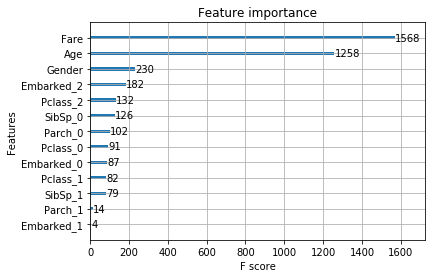

In [29]:
plot_importance(grid_xgb_clf.best_estimator_)

* Voting Ensanble 적용

In [30]:
# gridSeach 함수
# models = 모델들이 담겨있는 list
# parameters = 모델들의 파라미터 정보(dict)가 담겨있는 list
# X_train, y_train, X_test, y_test 학습시 필요
def model_gridSearch(models, parameters, X_train, X_test, y_train, y_test):
    results = []
    for model, parameter in zip(models, parameters):
        cv = KFold(n_splits=4)
        grid_model = GridSearchCV(
                        model, param_grid=parameter,
                        verbose=3, scoring='accuracy', cv=cv
                    )
        
        grid_model.fit(X_train_ss, y_train)
        grid_model_pred = grid_model.predict(X_test_ss)
        
        results.append(grid_model.best_estimator_)
    return results

In [38]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# 회귀 분류 모델 다 가져오기
lr_clf = LogisticRegression()
dt_clf = DecisionTreeClassifier()
knn_clf = KNeighborsClassifier()
xgb_clf = XGBClassifier()

models = [lr_clf, dt_clf, knn_clf, xgb_clf]

# 각각의 모델에 맞는 하이퍼 파라미터 셋 선언 및 저장
dt_param = {
    'max_depth' : [4,5,6],
    'max_features' : [3, 6, 9, 15]
}

lr_param = {
    'penalty' : ['l2'],
    'C' : [x * 0.1 for x in range(5,11,2)],
    'solver' : ['newton-cg', 'lbfgs','liblinear','sag','saga'],
    'max_iter' : [50,100,150]
}

knn_param = {
    'n_neighbors' : [3,5,7],
    'weights' : ['uniform', 'distance'],
    'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute']
}

xgb_param = {
        'n_estimators' : [ 1000 ],
        'max_depth' : [3,6,9],
        'min_child_weight' : [1,3,5],
        'gamma' : [ x/10.0 for x in range(0,5) ],
        'subsample' : [0.7],
        'colsample_bytree' : [0.8],
        'learning_rate' : [0.1],
        'n_jobs' : [4]
}

params = [lr_param, dt_param, knn_param, xgb_param]

In [39]:
from sklearn.ensemble import VotingClassifier

# model_gridSearch Function으로 최적 하이퍼 파라미터가 적용된 모델 가져오기
voting = model_gridSearch(models, params, X_train_onehot, X_test_onehot, y_train, y_test)

Fitting 4 folds for each of 45 candidates, totalling 180 fits
[CV] C=0.5, max_iter=50, penalty=l2, solver=newton-cg ................
[CV]  C=0.5, max_iter=50, penalty=l2, solver=newton-cg, score=0.7348484848484849, total=   0.0s
[CV] C=0.5, max_iter=50, penalty=l2, solver=newton-cg ................
[CV]  C=0.5, max_iter=50, penalty=l2, solver=newton-cg, score=0.6439393939393939, total=   0.0s
[CV] C=0.5, max_iter=50, penalty=l2, solver=newton-cg ................
[CV]  C=0.5, max_iter=50, penalty=l2, solver=newton-cg, score=0.7196969696969697, total=   0.0s
[CV] C=0.5, max_iter=50, penalty=l2, solver=newton-cg ................
[CV]  C=0.5, max_iter=50, penalty=l2, solver=newton-cg, score=0.7348484848484849, total=   0.0s
[CV] C=0.5, max_iter=50, penalty=l2, solver=lbfgs ....................
[CV]  C=0.5, max_iter=50, penalty=l2, solver=lbfgs, score=0.7348484848484849, total=   0.0s
[CV] C=0.5, max_iter=50, penalty=l2, solver=lbfgs ....................
[CV]  C=0.5, max_iter=50, penalty=l2

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV] C=0.5, max_iter=50, penalty=l2, solver=liblinear ................
[CV]  C=0.5, max_iter=50, penalty=l2, solver=liblinear, score=0.7196969696969697, total=   0.0s
[CV] C=0.5, max_iter=50, penalty=l2, solver=liblinear ................
[CV]  C=0.5, max_iter=50, penalty=l2, solver=liblinear, score=0.7348484848484849, total=   0.0s
[CV] C=0.5, max_iter=50, penalty=l2, solver=sag ......................
[CV]  C=0.5, max_iter=50, penalty=l2, solver=sag, score=0.7348484848484849, total=   0.0s
[CV] C=0.5, max_iter=50, penalty=l2, solver=sag ......................
[CV]  C=0.5, max_iter=50, penalty=l2, solver=sag, score=0.6439393939393939, total=   0.0s
[CV] C=0.5, max_iter=50, penalty=l2, solver=sag ......................
[CV]  C=0.5, max_iter=50, penalty=l2, solver=sag, score=0.7196969696969697, total=   0.0s
[CV] C=0.5, max_iter=50, penalty=l2, solver=sag ......................
[CV]  C=0.5, max_iter=50, penalty=l2, solver=sag, score=0.7348484848484849, total=   0.0s
[CV] C=0.5, max_iter=

[CV]  C=0.7000000000000001, max_iter=50, penalty=l2, solver=newton-cg, score=0.6439393939393939, total=   0.0s
[CV] C=0.7000000000000001, max_iter=50, penalty=l2, solver=newton-cg .
[CV]  C=0.7000000000000001, max_iter=50, penalty=l2, solver=newton-cg, score=0.7348484848484849, total=   0.0s
[CV] C=0.7000000000000001, max_iter=50, penalty=l2, solver=newton-cg .
[CV]  C=0.7000000000000001, max_iter=50, penalty=l2, solver=newton-cg, score=0.7424242424242424, total=   0.0s
[CV] C=0.7000000000000001, max_iter=50, penalty=l2, solver=lbfgs .....
[CV]  C=0.7000000000000001, max_iter=50, penalty=l2, solver=lbfgs, score=0.7424242424242424, total=   0.0s
[CV] C=0.7000000000000001, max_iter=50, penalty=l2, solver=lbfgs .....
[CV]  C=0.7000000000000001, max_iter=50, penalty=l2, solver=lbfgs, score=0.6439393939393939, total=   0.0s
[CV] C=0.7000000000000001, max_iter=50, penalty=l2, solver=lbfgs .....
[CV]  C=0.7000000000000001, max_iter=50, penalty=l2, solver=lbfgs, score=0.7348484848484849, total

[CV]  C=0.7000000000000001, max_iter=150, penalty=l2, solver=lbfgs, score=0.7424242424242424, total=   0.0s
[CV] C=0.7000000000000001, max_iter=150, penalty=l2, solver=liblinear 
[CV]  C=0.7000000000000001, max_iter=150, penalty=l2, solver=liblinear, score=0.7424242424242424, total=   0.0s
[CV] C=0.7000000000000001, max_iter=150, penalty=l2, solver=liblinear 
[CV]  C=0.7000000000000001, max_iter=150, penalty=l2, solver=liblinear, score=0.6515151515151515, total=   0.0s
[CV] C=0.7000000000000001, max_iter=150, penalty=l2, solver=liblinear 
[CV]  C=0.7000000000000001, max_iter=150, penalty=l2, solver=liblinear, score=0.7348484848484849, total=   0.0s
[CV] C=0.7000000000000001, max_iter=150, penalty=l2, solver=liblinear 
[CV]  C=0.7000000000000001, max_iter=150, penalty=l2, solver=liblinear, score=0.7424242424242424, total=   0.0s
[CV] C=0.7000000000000001, max_iter=150, penalty=l2, solver=sag ......
[CV]  C=0.7000000000000001, max_iter=150, penalty=l2, solver=sag, score=0.742424242424242

[CV]  C=0.9, max_iter=150, penalty=l2, solver=lbfgs, score=0.7424242424242424, total=   0.0s
[CV] C=0.9, max_iter=150, penalty=l2, solver=lbfgs ...................
[CV]  C=0.9, max_iter=150, penalty=l2, solver=lbfgs, score=0.6515151515151515, total=   0.0s
[CV] C=0.9, max_iter=150, penalty=l2, solver=lbfgs ...................
[CV]  C=0.9, max_iter=150, penalty=l2, solver=lbfgs, score=0.7348484848484849, total=   0.0s
[CV] C=0.9, max_iter=150, penalty=l2, solver=lbfgs ...................
[CV]  C=0.9, max_iter=150, penalty=l2, solver=lbfgs, score=0.7348484848484849, total=   0.0s
[CV] C=0.9, max_iter=150, penalty=l2, solver=liblinear ...............
[CV]  C=0.9, max_iter=150, penalty=l2, solver=liblinear, score=0.7424242424242424, total=   0.0s
[CV] C=0.9, max_iter=150, penalty=l2, solver=liblinear ...............
[CV]  C=0.9, max_iter=150, penalty=l2, solver=liblinear, score=0.6515151515151515, total=   0.0s
[CV] C=0.9, max_iter=150, penalty=l2, solver=liblinear ...............
[CV]  C=

[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV] max_depth=5, max_features=6 .....................................
[CV]  max_depth=5, max_features=6, score=0.7272727272727273, total=   0.0s
[CV] max_depth=5, max_features=9 .....................................
[CV]  max_depth=5, max_features=9, score=0.7196969696969697, total=   0.0s
[CV] max_depth=5, max_features=9 .....................................
[CV]  max_depth=5, max_features=9, score=0.6439393939393939, total=   0.0s
[CV] max_depth=5, max_features=9 .....................................
[CV]  max_depth=5, max_features=9, score=0.7424242424242424, total=   0.0s
[CV] max_depth=5, max_features=9 .....................................
[CV]  max_depth=5, max_features=9, score=0.7272727272727273, total=   0.0s
[CV] max_depth=5, max_features=15 ....................................
[CV]  max_depth=5, max_features=15, score=0.7121212121212122, total=   0.0s
[CV] max_depth=5, max_features=15 ....................................
[CV]  max_depth=5, max_features=15, score=0.6363636

[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


Fitting 4 folds for each of 24 candidates, totalling 96 fits
[CV] algorithm=auto, n_neighbors=3, weights=uniform ..................
[CV]  algorithm=auto, n_neighbors=3, weights=uniform, score=0.6136363636363636, total=   0.0s
[CV] algorithm=auto, n_neighbors=3, weights=uniform ..................
[CV]  algorithm=auto, n_neighbors=3, weights=uniform, score=0.6515151515151515, total=   0.0s
[CV] algorithm=auto, n_neighbors=3, weights=uniform ..................
[CV]  algorithm=auto, n_neighbors=3, weights=uniform, score=0.7045454545454546, total=   0.0s
[CV] algorithm=auto, n_neighbors=3, weights=uniform ..................
[CV]  algorithm=auto, n_neighbors=3, weights=uniform, score=0.7121212121212122, total=   0.0s
[CV] algorithm=auto, n_neighbors=3, weights=distance .................
[CV]  algorithm=auto, n_neighbors=3, weights=distance, score=0.6136363636363636, total=   0.0s
[CV] algorithm=auto, n_neighbors=3, weights=distance .................
[CV]  algorithm=auto, n_neighbors=3, weigh

[CV]  algorithm=kd_tree, n_neighbors=3, weights=distance, score=0.7196969696969697, total=   0.0s
[CV] algorithm=kd_tree, n_neighbors=5, weights=uniform ...............
[CV]  algorithm=kd_tree, n_neighbors=5, weights=uniform, score=0.6590909090909091, total=   0.0s
[CV] algorithm=kd_tree, n_neighbors=5, weights=uniform ...............
[CV]  algorithm=kd_tree, n_neighbors=5, weights=uniform, score=0.7045454545454546, total=   0.0s
[CV] algorithm=kd_tree, n_neighbors=5, weights=uniform ...............
[CV]  algorithm=kd_tree, n_neighbors=5, weights=uniform, score=0.7348484848484849, total=   0.0s
[CV] algorithm=kd_tree, n_neighbors=5, weights=uniform ...............
[CV]  algorithm=kd_tree, n_neighbors=5, weights=uniform, score=0.6742424242424242, total=   0.0s
[CV] algorithm=kd_tree, n_neighbors=5, weights=distance ..............
[CV]  algorithm=kd_tree, n_neighbors=5, weights=distance, score=0.6363636363636364, total=   0.0s
[CV] algorithm=kd_tree, n_neighbors=5, weights=distance .....

[Parallel(n_jobs=1)]: Done  96 out of  96 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=1000, n_jobs=4, subsample=0.7, score=0.7348484848484849, total=   0.2s
[CV] colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=1000, n_jobs=4, subsample=0.7 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=1000, n_jobs=4, subsample=0.7, score=0.6515151515151515, total=   0.3s
[CV] colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=1000, n_jobs=4, subsample=0.7 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


[CV]  colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=1000, n_jobs=4, subsample=0.7, score=0.7045454545454546, total=   0.2s
[CV] colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=1000, n_jobs=4, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=1000, n_jobs=4, subsample=0.7, score=0.7272727272727273, total=   0.2s
[CV] colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=1000, n_jobs=4, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=1000, n_jobs=4, subsample=0.7, score=0.7348484848484849, total=   0.2s
[CV] colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=1000, n_jobs=4, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=3, mi

[CV]  colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=9, min_child_weight=3, n_estimators=1000, n_jobs=4, subsample=0.7, score=0.6439393939393939, total=   0.3s
[CV] colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=9, min_child_weight=3, n_estimators=1000, n_jobs=4, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=9, min_child_weight=3, n_estimators=1000, n_jobs=4, subsample=0.7, score=0.696969696969697, total=   0.3s
[CV] colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=9, min_child_weight=3, n_estimators=1000, n_jobs=4, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=9, min_child_weight=3, n_estimators=1000, n_jobs=4, subsample=0.7, score=0.7272727272727273, total=   0.4s
[CV] colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=9, min_child_weight=5, n_estimators=1000, n_jobs=4, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=9, min

[CV]  colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, n_jobs=4, subsample=0.7, score=0.7272727272727273, total=   0.3s
[CV] colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, n_jobs=4, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, n_jobs=4, subsample=0.7, score=0.6439393939393939, total=   0.2s
[CV] colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, n_jobs=4, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, n_jobs=4, subsample=0.7, score=0.7424242424242424, total=   0.2s
[CV] colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, n_jobs=4, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=6, mi

[CV]  colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=1000, n_jobs=4, subsample=0.7, score=0.7196969696969697, total=   0.2s
[CV] colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=1000, n_jobs=4, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=1000, n_jobs=4, subsample=0.7, score=0.7348484848484849, total=   0.3s
[CV] colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=1000, n_jobs=4, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=1000, n_jobs=4, subsample=0.7, score=0.6363636363636364, total=   0.3s
[CV] colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=1000, n_jobs=4, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=6, mi

[CV]  colsample_bytree=0.8, gamma=0.3, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=1000, n_jobs=4, subsample=0.7, score=0.7045454545454546, total=   0.2s
[CV] colsample_bytree=0.8, gamma=0.3, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=1000, n_jobs=4, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.3, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=1000, n_jobs=4, subsample=0.7, score=0.7272727272727273, total=   0.2s
[CV] colsample_bytree=0.8, gamma=0.3, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=1000, n_jobs=4, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.3, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=1000, n_jobs=4, subsample=0.7, score=0.7424242424242424, total=   0.2s
[CV] colsample_bytree=0.8, gamma=0.3, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=1000, n_jobs=4, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.3, learning_rate=0.1, max_depth=3, mi

[CV]  colsample_bytree=0.8, gamma=0.3, learning_rate=0.1, max_depth=9, min_child_weight=3, n_estimators=1000, n_jobs=4, subsample=0.7, score=0.6439393939393939, total=   0.2s
[CV] colsample_bytree=0.8, gamma=0.3, learning_rate=0.1, max_depth=9, min_child_weight=3, n_estimators=1000, n_jobs=4, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.3, learning_rate=0.1, max_depth=9, min_child_weight=3, n_estimators=1000, n_jobs=4, subsample=0.7, score=0.7121212121212122, total=   0.3s
[CV] colsample_bytree=0.8, gamma=0.3, learning_rate=0.1, max_depth=9, min_child_weight=3, n_estimators=1000, n_jobs=4, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.3, learning_rate=0.1, max_depth=9, min_child_weight=3, n_estimators=1000, n_jobs=4, subsample=0.7, score=0.7272727272727273, total=   0.2s
[CV] colsample_bytree=0.8, gamma=0.3, learning_rate=0.1, max_depth=9, min_child_weight=5, n_estimators=1000, n_jobs=4, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.3, learning_rate=0.1, max_depth=9, mi

[CV]  colsample_bytree=0.8, gamma=0.4, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, n_jobs=4, subsample=0.7, score=0.75, total=   0.2s
[CV] colsample_bytree=0.8, gamma=0.4, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, n_jobs=4, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.4, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, n_jobs=4, subsample=0.7, score=0.6363636363636364, total=   0.2s
[CV] colsample_bytree=0.8, gamma=0.4, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, n_jobs=4, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.4, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, n_jobs=4, subsample=0.7, score=0.75, total=   0.2s
[CV] colsample_bytree=0.8, gamma=0.4, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=1000, n_jobs=4, subsample=0.7 
[CV]  colsample_bytree=0.8, gamma=0.4, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimato

[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  1.1min finished


In [41]:
# voting 모델에 적용 및 학습, 예측
voting = [('Logistic', voting[0]),('Decision',voting[1]),
          ('KNeighbors',voting[2]),('XGBoost',voting[3])]

voting_clf = VotingClassifier(
                    estimators = voting,
                    voting = 'soft'
            )

voting_clf.fit(X_train_onehot, y_train)
voting_pred = voting_clf.predict(X_test_onehot)

print(accuracy_score(y_test, voting_pred))
print(roc_auc_score(y_test, voting_pred))
print(classification_report(y_test, voting_pred))

0.8193832599118943
0.7807823129251701
              precision    recall  f1-score   support

           0       0.83      0.91      0.87       147
           1       0.80      0.65      0.72        80

   micro avg       0.82      0.82      0.82       227
   macro avg       0.81      0.78      0.79       227
weighted avg       0.82      0.82      0.81       227

